## Training a Classifier on the PatchCamelyon Dataset

This is what you find below:

A MobileNet classifier implemented in Keras and partially trained on the PCam dataset using the data augmentation pipeline described in the paper ["Detecting Cancer Metastases on Gigapixel Pathology Images"](https://arxiv.org/abs/1703.02442).

I had to train on a CPU, so what you see below is just 2000 training steps. That's also why I picked a MobileNet instead of something bigger. Loss and accuracy are going in the right direction. The reason why the validation loss and accuracy are all over the place is because they are computed over a different portion of the validation dataset each time (once again, can't run on the whole validation dataset on a CPU), but the trend is right.

I was going to use Keras' built-in image data generator, but that turned out not to work HDF5 datasets, so I adapted a generator for 2D object detection that I had built a while ago.

In [20]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Reshape, Dropout, Conv2D, Activation, Flatten
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import HDF5Matrix
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras.models import load_model
import numpy as np
import csv
from matplotlib import pyplot as plt
%matplotlib inline

from data_generator.classification_data_generator import DataGenerator
from data_generator.classification_photometric_ops import Standardize
from data_generator.data_augmentation_chain_satellite import DataAugmentationSatellite

### Build the model

In [2]:
alpha = 1.0
n_classes = 2
dropout = 1e-3

K.clear_session() # Clear previous models from memory.

# Load MobileNet without the final fully connected layer.

base_model = MobileNet(input_shape=(96, 96, 3),
                       alpha=alpha,
                       depth_multiplier=1,
                       dropout=dropout,
                       include_top=False,
                       weights=None, #'imagenet',
                       pooling=None)

# Add the final layers.

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Reshape((1, 1, int(1024 * alpha)), name='reshape_1')(x)
x = Dropout(dropout, name='dropout')(x)
x = Conv2D(n_classes,
           (1, 1),
           padding='same',
           name='conv_preds')(x)
x = Activation('softmax', name='act_softmax')(x)
x = Reshape((n_classes,), name='reshape_2')(x)

model = Model(inputs=base_model.input, outputs=x)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

### Visualize the data

In [5]:
train_x_path = '../../Downloads/camelyonpatch_level_2_split_train_x.h5'
train_y_path = '../../Downloads/camelyonpatch_level_2_split_train_y.h5'

train_x = HDF5Matrix(datapath=train_x_path, dataset='x', start=0, end=None)
train_y = HDF5Matrix(datapath=train_y_path, dataset='y', start=0, end=None)

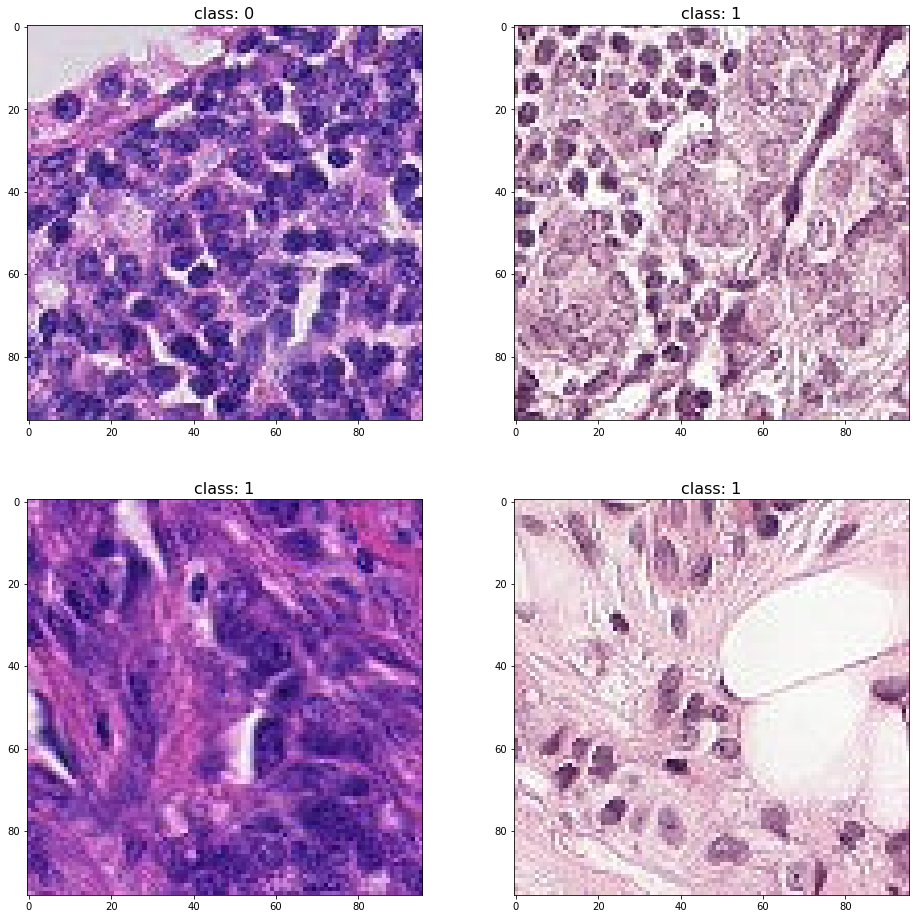

In [6]:
i = 0
m = 2
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
cells[0,0].imshow(train_x[i])
cells[0,0].set_title('class: {}'.format(str(np.squeeze(train_y[i]))), fontsize=16)
cells[0,1].imshow(train_x[i+1])
cells[0,1].set_title('class: {}'.format(str(np.squeeze(train_y[i+1]))), fontsize=16)
cells[1,0].imshow(train_x[i+2])
cells[1,0].set_title('class: {}'.format(str(np.squeeze(train_y[i+2]))), fontsize=16)
cells[1,1].imshow(train_x[i+3])
cells[1,1].set_title('class: {}'.format(str(np.squeeze(train_y[i+3]))), fontsize=16)

### Set up the training and validation generators 

In [7]:
train_x_path = '../../Downloads/camelyonpatch_level_2_split_train_x.h5'
train_y_path = '../../Downloads/camelyonpatch_level_2_split_train_y.h5'
val_x_path = '../../Downloads/camelyonpatch_level_2_split_valid_x.h5'
val_y_path = '../../Downloads/camelyonpatch_level_2_split_valid_y.h5'

train_dataset = DataGenerator(hdf5_images_path=train_x_path,
                              hdf5_images_dataset='x',
                              hdf5_labels_path=train_y_path,
                              hdf5_labels_dataset='y',
                              n_classes=n_classes)

val_dataset = DataGenerator(hdf5_images_path=val_x_path,
                            hdf5_images_dataset='x',
                            hdf5_labels_path=val_y_path,
                            hdf5_labels_dataset='y',
                            n_classes=n_classes)

In [8]:
augmentation_chain = DataAugmentationSatellite(resize=False,
                                               subtrahend=127.5,
                                               divisor=127.5,
                                               random_brightness=(-64, 64, 0.5),
                                               random_contrast=(0.25, 1.75, 0.5),
                                               random_saturation=(0.75, 1.25, 0.5),
                                               random_hue=(14, 0.5),
                                               random_flip=0.5,
                                               random_rotate=([90, 180, 270], 0.5))

standardize = Standardize(subtrahend=127.5, divisor=127.5)

In [9]:
train_generator = train_dataset.generate(batch_size=32,
                                         shuffle=True,
                                         transformations=[augmentation_chain],
                                         to_one_hot=True,
                                         returns={'processed_images', 'labels'})

val_generator = val_dataset.generate(batch_size=32,
                                     shuffle=False,
                                     transformations=[standardize],
                                     to_one_hot=True,
                                     returns={'processed_images', 'labels'})

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size = val_dataset.get_dataset_size()
print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	262144
Number of images in the validation dataset:	 32768


Visualize some generated images to make sure that the augmentation chain produces the expected results.

In [10]:
batch_images, batch_labels = next(train_generator)

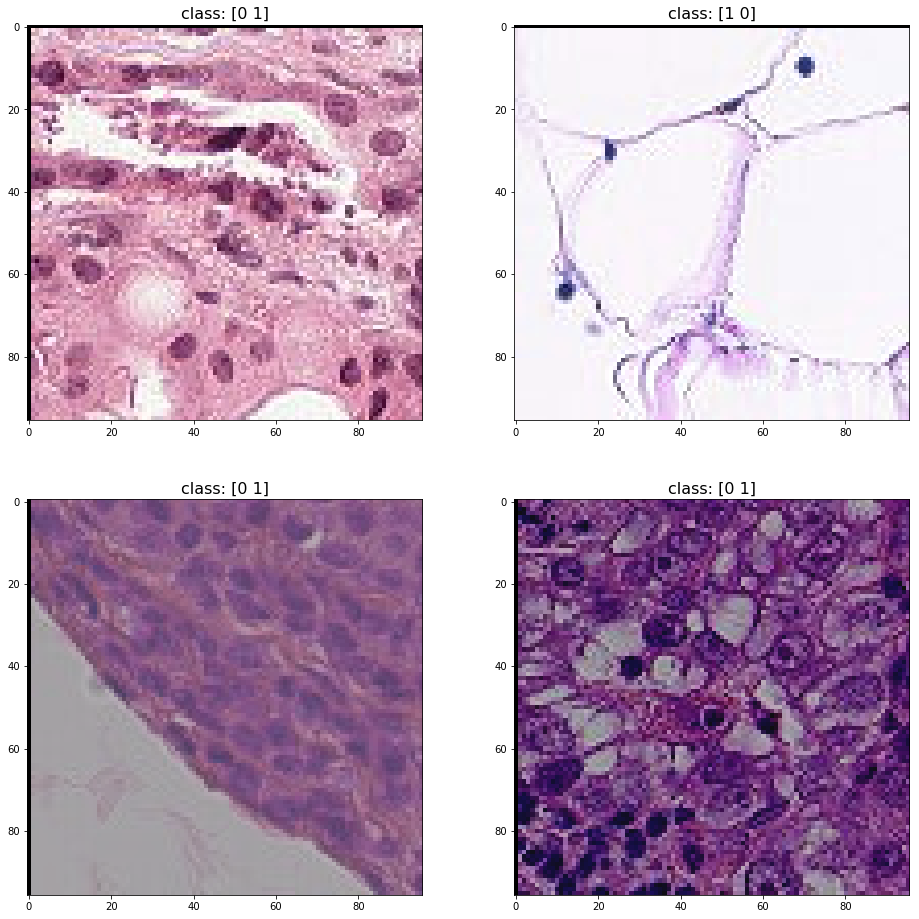

In [12]:
i = 0
m = 2
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
cells[0,0].imshow(batch_images[i])
cells[0,0].set_title('class: {}'.format(batch_labels[i]), fontsize=16)
cells[0,1].imshow(batch_images[i+1])
cells[0,1].set_title('class: {}'.format(batch_labels[i+1]), fontsize=16)
cells[1,0].imshow(batch_images[i+2])
cells[1,0].set_title('class: {}'.format(batch_labels[i+2]), fontsize=16)
cells[1,1].imshow(batch_images[i+3])
cells[1,1].set_title('class: {}'.format(batch_labels[i+3]), fontsize=16)

### Set up the training

In [11]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [16]:
# Define a few useful model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='mobilenet_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=False,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='mobilenet_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

### Train

In [17]:
initial_epoch   = 0
final_epoch     = 10
steps_per_epoch = 100

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=steps_per_epoch,
                              initial_epoch=initial_epoch)

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
100/100 [==============================] - 317s 3s/step - loss: 0.5411 - acc: 0.7375 - val_loss: 0.4792 - val_acc: 0.7622

### Let's look at the progress so far

In [26]:
loss     = []
val_loss = []
acc      = []
val_acc  = []

with open('mobilenet_training_log.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # Skip the header row.
    for row in reader:
        acc.append(float(row[1]))
        loss.append(float(row[2]))
        val_acc.append(float(row[3]))
        val_loss.append(float(row[4]))

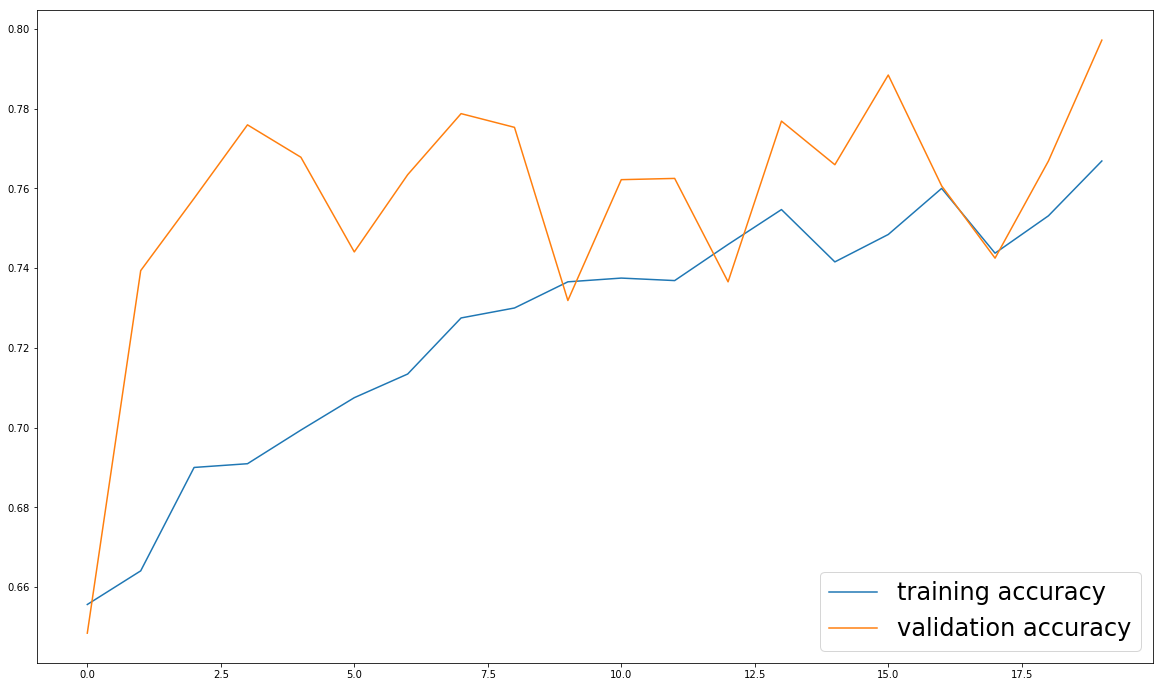

In [28]:
plt.figure(figsize=(20,12))
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='lower right', prop={'size': 24});

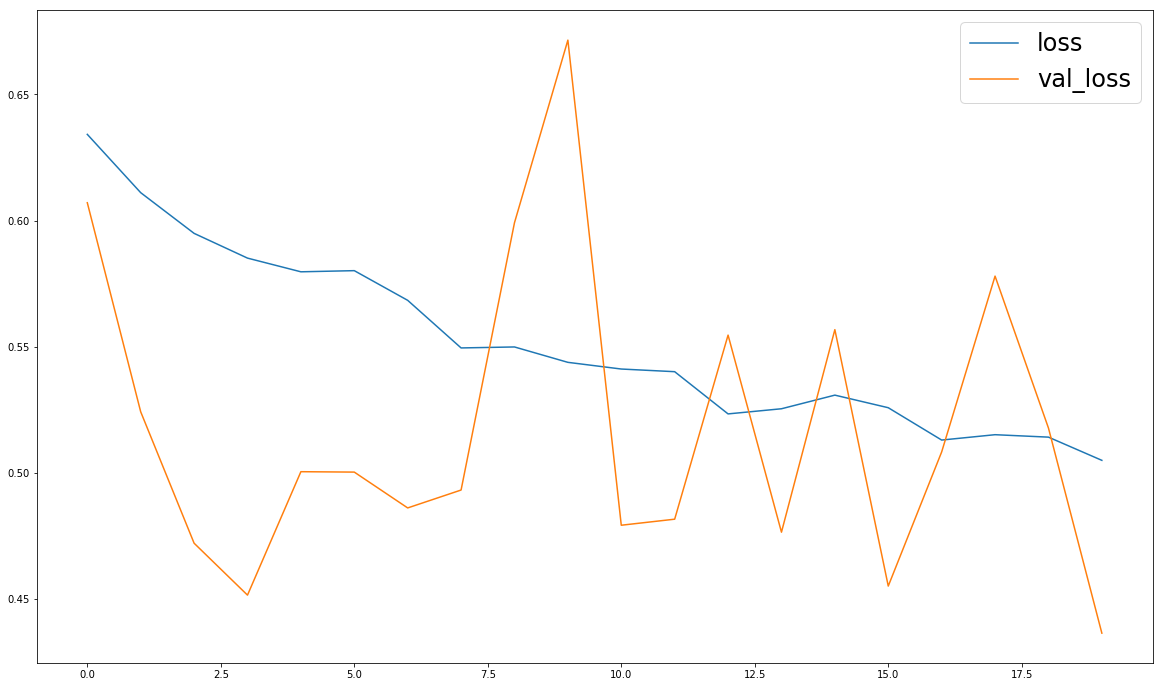

In [29]:
plt.figure(figsize=(20,12))
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});